In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from mtcnn.mtcnn import MTCNN

import tkinter
from tkinter.filedialog import askopenfilename

filename = None

In [2]:
def imgselect():
    global filename 
    filename = askopenfilename()
    root.destroy()

In [3]:
def draw_box(img, faces, top_left):
    pyplot.imshow(img)
    ax = pyplot.gca()
    for face in faces:
        x, y, width, height = face['box']
        x = x + top_left[1]
        y = y + top_left[0]
        rect = Rectangle((x, y), width, height, fill=False, color='red')
        ax.add_patch(rect)
    pyplot.show()

In [4]:
def update_corners(top_left, bottom_right, shape, inc):
    y1, x1 = top_left
    y2, x2 = bottom_right
    h = shape[0]
    w = shape[1]
    if y1 < 0:
        y1 = 0
        y2 = 2 * inc
    elif y2 >= h:
        y2 = h
        y1 = h - (2 * inc)
    if x1 < 0:
        x1 = 0
        x2 = 2 * inc
    elif x2 >= w:
        x2 = w
        x1 = w - (2 * inc)
    return ((y1, x1), (y2, x2))

In [5]:
def crop(event, x, y, flags, param):
    inc = 75
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x, y)
        print(img.shape)
        length = min(img.shape[0], img.shape[1])
        detector = MTCNN()
        faces_in_vicinity = False
        full_img = pyplot.imread(filename)
        while (2 * inc <= length):
            top_left = y - inc, x - inc
            bottom_right = y + inc, x + inc
            top_left, bottom_right = update_corners(top_left, bottom_right, img.shape, inc)
            print(top_left, bottom_right)
            crop_img = img[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
            print(crop_img.shape)
            cv2.imwrite('image/1/save1.jpg', crop_img)
            crop_img = pyplot.imread('image/1/save1.jpg')
            faces = detector.detect_faces(crop_img)
            print(faces)
            if len(faces) > 0:
                draw_box(full_img, faces, top_left)
                faces_in_vicinity = True
                break
            else:
                inc = inc + (length // 10)
        if faces_in_vicinity is False:
            faces = detector.detect_faces(full_img)
            print(full_img.shape)
            print(faces)
            if len(faces) == 0:
                print('The network failed to find faces in this image.')
            else:
                draw_box(full_img, faces, (0, 0))

152 216
(400, 400, 3)
(141, 77) (291, 227)
(150, 150, 3)
[{'box': [15, -26, 128, 164], 'confidence': 0.9991045594215393, 'keypoints': {'left_eye': (30, 26), 'right_eye': (89, 22), 'nose': (38, 65), 'mouth_left': (36, 102), 'mouth_right': (87, 100)}}]


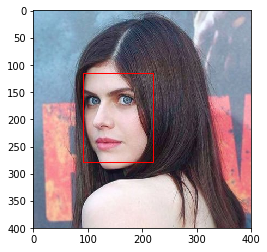

In [12]:
root = tkinter.Tk()
root.title('Photo tagging - Image selector')
label1 = tkinter.Label(root, text = 'Select an image', width = 50, font = ('Bookman Old Style', 25))
label1.grid(row = 0, column = 1, pady = 40)
button = tkinter.Button(root, text = 'Choose', command = imgselect, width = 10, pady = 10, font = ('Bookman Old Style', 25))
button.grid(row = 1, column = 1, pady = 10)
root.mainloop()

cv2.namedWindow("image")
img = cv2.imread(filename)
cv2.setMouseCallback("image", crop)
cv2.imshow("image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [13]:
import keras
model = keras.models.load_model('nweights.h5')

In [14]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()

In [15]:
one = datagen.flow_from_directory('image', class_mode='categorical', batch_size=1, shuffle = False)

Found 1 images belonging to 1 classes.


In [16]:
import numpy as np
v = model.predict(one)
a = np.argmax(v[0])
print(np.argmax(v[0]))

355


In [17]:
import imutils
aligned_img = imutils.rotate(cv2.imread('image/1/save1.jpg'), -np.argmax(v[0]))
cv2.imwrite('align/unknown_image.jpg', aligned_img)
# cv2.imshow('aligned image', aligned_img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

True

Checking -  Aaron Paul
Checking -  alexandra daddario
Our recommendation is:  alexandra daddario
Here is one of the images that matched: 


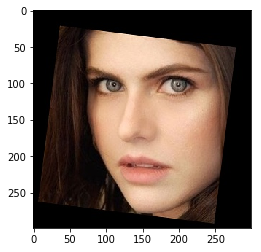

In [18]:
import face_recognition
import glob

unknown_image = face_recognition.load_image_file('align/unknown_image.jpg')
try:
    unknown_face_encoding = face_recognition.face_encodings(unknown_image)[0]
except IndexError:
    print('Searching face')
    if a >= 45 and a <= 315:
        unknown_image = face_recognition.load_image_file('image/1/save1.jpg')
        try:
            unknown_face_encoding = face_recognition.face_encodings(unknown_image)[0]
        except IndexError:
            print("The network couldn't find any faces in this image.")
            quit()

people = glob.glob('database/*')
found = False

for person in people:
    name = os.path.split(person)[1].split('_')[1]
    print('Checking - ', name)
    photos = glob.glob(os.path.join(person, '*'))
    known_faces = []
    for photo in photos:
        target_image = face_recognition.load_image_file(photo)
        try:
            target_face_encoding = face_recognition.face_encodings(target_image)[0]
        except IndexError:
            continue
        known_faces.append(target_face_encoding)
    
    # print(len(known_faces))
    results = face_recognition.compare_faces(known_faces, unknown_face_encoding)
    
    if True in results:
        found = True
        print('Our recommendation is: ', name)
        print('Here is one of the images that matched: ')
        img = pyplot.imread(photos[results.index(True)])
        pyplot.imshow(img)
        pyplot.show()
        break
    
if found is False:
    print('This person does not exist in the database.')